# Local minima in a matrix

* <https://adventofcode.com/2021/day/9>

We have to find the local minima in a matrix; you can't get away with having to test every single value for this. However, as always when matrices are involved, we can use numpy to find the answer.

You can shift the matrix in all four directions and pad with 10s for the edges (since all values are between 0 and 9), then compare between the shifted matrices in a single step. That gives us a boolean matrix for the local minima, allowing us to select just those values, add one and sum the values.

In [1]:
from __future__ import annotations
from typing import Final
import numpy as np

PAD_SPEC = tuple[tuple[int, int], tuple[int, int]]
SLICE_SPEC = tuple[slice, slice]
SHIFTS: Final[tuple[tuple[PAD_SPEC, SLICE_SPEC], ...]] = (
    (((1, 0), (0, 0)), (slice(None, -1), ...)),
    (((0, 1), (0, 0)), (slice(1, None), ...)),
    (((0, 0), (1, 0)), (..., slice(None, -1))),
    (((0, 0), (0, 1)), (..., slice(1, None))),
)


def find_risk_levels(heightmap: np.array) -> np.array:
    risky = np.ones(heightmap.shape, dtype=bool)
    for pad_spec, slice_spec in SHIFTS:
        risky &= heightmap < np.pad(heightmap, pad_spec, constant_values=10)[slice_spec]
    return heightmap[risky] + 1


test_heightmap = np.genfromtxt(
    """\
2199943210
3987894921
9856789892
8767896789
9899965678
""".splitlines(),
    dtype=np.uint8,
    delimiter=1,
)
assert find_risk_levels(test_heightmap).sum() == 15


In [2]:
import aocd

heightmap = np.genfromtxt(
    aocd.get_data(day=9, year=2021).splitlines(), dtype=np.uint8, delimiter=1
)
print("Part 1:", find_risk_levels(heightmap).sum())


Part 1: 594


# Part 2: sizing areas

The second part essentially asks us to find the largest contiguous areas of values not equal to 9.

We can use the SciPy [`scipy.ndimage.label()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html) to do this work for us. This essentially gives each area that is non-zero a label. We'll need to 'invert' our heightmap by subtracting it from 9, so all 9s become zeros, and all zeros become 9s, and the other values ranging in between. The return value is a matrix with the same shape but each area 'filled' with a unique integer greater than 0. We can then count the different labels and so extract the 3 highest counts.

In [3]:
from scipy.ndimage import label


def three_largest_basins(heightmap: np.array) -> np.array:
    labeled, _ = label(9 - heightmap)
    _, counts = np.unique(labeled[labeled != 0], return_counts=True)
    return -np.partition(-counts, 3)[:3]


assert np.prod(three_largest_basins(test_heightmap)) == 1134


In [4]:
print("Part 2:", np.prod(three_largest_basins(heightmap)))


Part 2: 858494


# Visualisation

Much more interesting would be to show the basins themselves; we can use the `label()` output to pick colours.

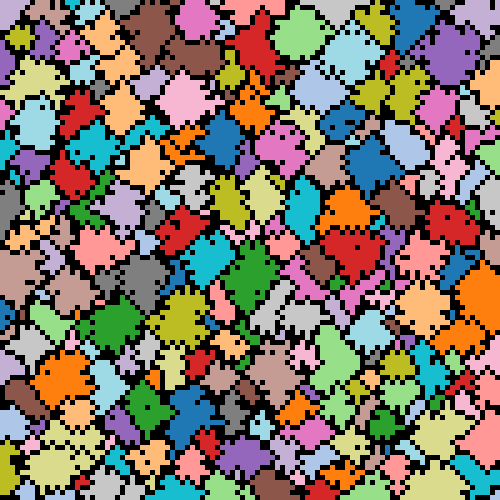

In [5]:
from PIL import Image
from matplotlib import cm
from matplotlib.colors import ListedColormap


def basin_map(heightmap: np.array) -> np.array:
    labeled, count = label(9 - heightmap)
    lrange = np.linspace(0, 1, count)
    np.random.default_rng(count).shuffle(lrange)  # semi-random, but deterministic
    cmap = ListedColormap(cm.get_cmap("tab20", count)(lrange))
    # colour edges black by pushing the value outside the range and using cm.set_under()
    labeled[labeled == 0] = -1
    cmap.set_under("black")
    return Image.fromarray(cmap(labeled, bytes=True)).resize((500, 500), Image.NEAREST)


basin_map(heightmap)
